In [2]:
import torch
import numpy as np
from mlp_mixer import MLPMixer

DataLoader

In [3]:
#pip install scikit-learn
#!pip install numpy
#pip install 
!pip install pydicom

DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

        
class DICOMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.records = self._load_records()        
        
    '''def _load_records(self):
        records = []
        
        labels_dirs = {'NOT_MI_F_echo (1)': 0, 'MI_F_echo (2)': 1}
        
        for label, index in labels_dirs.items(): #레이블과 인덱스 매핑
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir): #디렉토리 탐색
                patient_dir = os.path.join(label_dir, patient)
                #for session in os.listdir(patient_dir): #환자 디렉토리 탐색
                    #session_dir = os.path.join(patient_dir, session)
                for file in os.listdir(patient_dir):
                    if file.lower().endswith('.dcm'):
                        file_path = os.path.join(patient_dir, file)
                        records.append((file_path, index))
        
        return records'''
    
    def _load_records(self):
        records = []
        
        # 'echo' 디렉토리 내의 레이블 디렉토리 ('not_mi_f', 'mi_f') 매핑
        labels_dirs = {'NOT_MI_F_echo (1)': 0, 'MI_F_echo (2)': 1}
        
        # 'echo' 디렉토리 경로
        echo_dir = os.path.join(self.root_dir)

        for label, index in labels_dirs.items():
            label_dir = os.path.join(echo_dir, label)
            
            # 주어진 레이블 디렉토리에 대한 환자 디렉토리 탐색
            if not os.path.isdir(label_dir):
                print(f"Directory not found: {label_dir}")
                continue
            
            # 환자 디렉토리 내에서 DICOM 파일을 탐색
            for root, dirs, files in os.walk(label_dir):
                for file in files:
                    if file.lower().endswith('.dcm'):
                        file_path = os.path.join(root, file)
                        records.append((file_path, index))

        return records


    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        file_path, label = self.records[idx]
        dicom = pydicom.dcmread(file_path)
        
        # 멀티프레임 이미지인 경우 중간 프레임을 선택
        frame = dicom.pixel_array
        if 'NumberOfFrames' in dicom:
            middle_frame_index = dicom.NumberOfFrames // 2
            frame = frame[middle_frame_index]

        # 이미지 정규화 및 8비트 변환
        frame = np.clip((frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255, 0, 255).astype(np.uint8)
        
        # PIL 이미지로 변환
        img = Image.fromarray(frame).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label





In [5]:
# 데이터 전처리 및 데이터셋 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(contrast=2.0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

root_dir = 'C:/Users/hongi/Downloads/echo'  # 수정: DICOM 파일이 저장된 최상위 디렉토리로 변경
dataset = DICOMDataset(root_dir=root_dir, transform=transform)

# 데이터셋 사용 예시
# DataLoader를 생성하여 훈련 과정에서 사용할 수 있습니다.
# 예: train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:
print(len(dataset))

706


In [7]:
# 데이터셋 인스턴스 생성
# 여기서 'your_root_dir'는 DICOM 이미지들이 저장된 최상위 디렉토리의 경로로 바꿔야 합니다.
#dataset = DICOMDataset(root_dir='C:/Users/hongi/Downloads/echo', transform=None)

# 데이터셋에서 몇 개의 샘플을 랜덤으로 선택하여 출력
import random

for i in range(10):  # 5개의 랜덤 샘플 출력
    idx = random.randint(0, len(dataset) - 1)
    _, label = dataset[idx]
    print(f'Sample index: {idx}, Label: {label}')

# 또는 처음부터 몇 개의 샘플을 순차적으로 출력
for i in range(5):  # 처음 5개 샘플 출력
    _, label = dataset[i]
    print(f'Sample index: {i}, Label: {label}')

Sample index: 40, Label: 0
Sample index: 56, Label: 0
Sample index: 162, Label: 0
Sample index: 445, Label: 1
Sample index: 111, Label: 0
Sample index: 187, Label: 0
Sample index: 666, Label: 1
Sample index: 375, Label: 1
Sample index: 206, Label: 0
Sample index: 51, Label: 0
Sample index: 0, Label: 0
Sample index: 1, Label: 0
Sample index: 2, Label: 0
Sample index: 3, Label: 0
Sample index: 4, Label: 0


In [8]:
# 첫 번째 이미지와 레이블을 데이터셋에서 불러오기
img, label = dataset[0]

# 이미지의 타입 출력
print("Image Type:", type(img))

# 이미지의 차원과 타입 확인
if hasattr(img, 'shape'):
    print("Image Shape:", img.shape)
elif hasattr(img, 'size'):
    print("Image Size:", img.size())

# 이미지의 픽셀 값 범위 확인 (옵션)
if hasattr(img, 'min') and hasattr(img, 'max'):
    print("Pixel Value Range:", img.min(), "-", img.max())


Image Type: <class 'torch.Tensor'>
Image Shape: torch.Size([3, 224, 224])
Pixel Value Range: tensor(-1.) - tensor(0.9529)


In [9]:
import pydicom

# DICOM 파일의 경로를 지정하세요
dicom_file_path = 'C:/Users/hongi/Downloads/echo/NOT_MI_F_echo (1)/NOT_MI_F_echo/p18/p18758318/90970660_0001.dcm'

# 파일 로드
dicom_data = pydicom.dcmread(dicom_file_path)

# DICOM 파일의 메타데이터 출력
print(dicom_data)

# 픽셀 데이터의 속성 확인
print("Shape of Pixel Data:", dicom_data.pixel_array.shape)
print("Data Type of Pixel Data:", dicom_data.pixel_array.dtype)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Ultrasound Multi-frame Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113554.6.1.101.810274809723027331655466869280411828676
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.6
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_366'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Ultrasound Multi-frame Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113554.6.1.101.284406436853106358489038272290350364404
(0008, 0020) Study Date                          DA: '21840616'
(0008, 0021) Series Date                         DA: '21840616'
(0008, 

In [10]:
import matplotlib.pyplot as plt

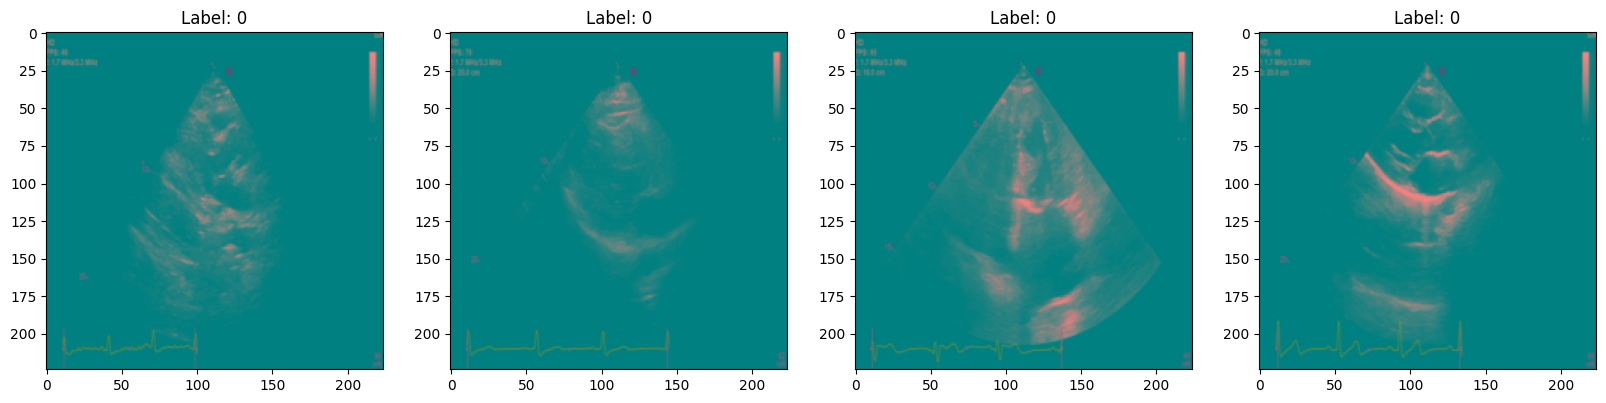

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    img, label = dataset[i]
    img = img.numpy().transpose((1, 2, 0))  # PyTorch 텐서를 numpy 배열로 변환하고, CHW를 HWC로 변경
    img = (img * 0.5 + 0.5)  # 정규화된 이미지를 [0, 1] 범위로 복원
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}')  # 이미지의 제목으로 레이블을 표시
    axes
    
plt.show()


In [12]:
from torch.utils.data import DataLoader, random_split

# 전체 데이터셋 크기 및 분할 비율 설정
total_size = len(dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = total_size - train_size - valid_size

# 데이터셋을 무작위로 분할
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)  # 검증 세트는 일반적으로 섞지 않지만 예시를 위해 shuffle=True 설정
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # 테스트 세트는 일반적으로 섞지 않음


In [13]:
print(len(train_dataset))  # 훈련 데이터셋의 크기
print(len(valid_dataset))    # 검증 데이터셋의 크기
print(len(test_dataset))   # 테스트 데이터셋의 크기

first_data_point, first_label = train_dataset[0]
print(first_data_point.shape)

# DataLoader에서 첫 번째 배치의 레이블을 확인하는 함수
def check_labels(data_loader, name):
    # DataLoader에서 첫 번째 배치를 가져옴
    first_batch = next(iter(data_loader))
    # 첫 번째 배치의 레이블을 가져옴
    labels = first_batch[1]
    print(f"{name} first batch labels: {labels}")

# 각 DataLoader에 대해 함수 호출
check_labels(train_loader, 'Train')
check_labels(valid_loader, 'Validation')
check_labels(test_loader, 'Test')


494
141
71
torch.Size([3, 224, 224])
Train first batch labels: tensor([0, 0, 1, 0, 0, 0, 0, 0])
Validation first batch labels: tensor([1, 1, 1, 0, 0, 0, 0, 0])
Test first batch labels: tensor([1, 0, 1, 0, 1, 1, 0, 0])


In [14]:
#!pip install matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


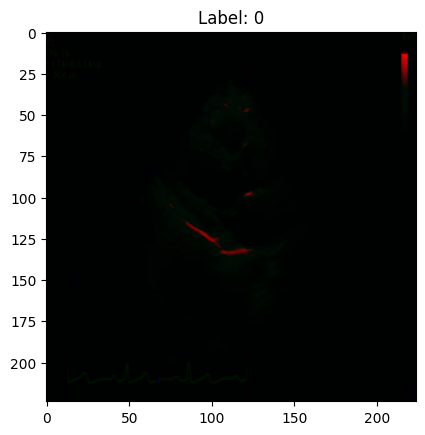

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


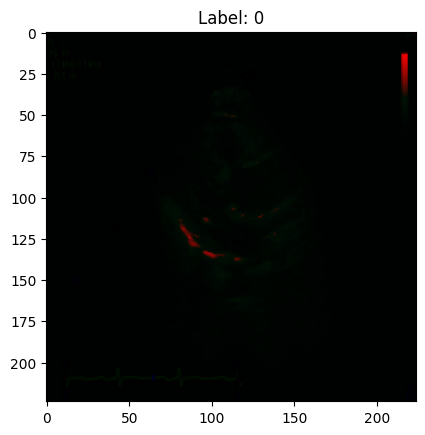

In [15]:
import matplotlib.pyplot as plt

# 훈련 데이터셋의 첫 번째 샘플 불러오기
img, label = train_dataset[1]


'''# 이미지의 차원을 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경
img = img.permute(1, 2, 0).numpy()

# 이미지 시각화 전에 정규화 복원 수행
# 이 단계는 이미 img가 [0, 1] 범위 내에 있기 때문에 필요하지 않을 수 있음
img = img * 0.5 + 0.5  # 만약 이미지가 [-1, 1] 범위로 정규화되었다면 이 복원 과정이 필요

# 이미지 시각화
plt.imshow(img)
plt.title(f'Label: {label}')
plt.show()
'''# 이미지 시각화
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f'Label: {label}')
plt.show()

import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# 이미지 변환을 위한 ToTensor 인스턴스 생성
to_tensor = ToTensor()

# 훈련 데이터셋의 첫 번째 샘플 불러오기
img, label = train_dataset[5]

# img가 PIL.Image 형태일 경우, ToTensor를 사용하여 변환
if not isinstance(img, torch.Tensor):
    img = to_tensor(img)

# 이미지 시각화
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f'Label: {label}')
plt.show()

resnet50


In [16]:
!pip install pandas

DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [17]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
from torchvision import models
import pandas as pd
from torch.utils.data.dataset import random_split

In [20]:
from tqdm import tqdm
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define your save directory
save_dir = 'C:/Users/hongi/Desktop/MLP-Mixer-pytorch-master/24w_MI_Multimodal_Prediction/runs/'


# Define the ResNet-50 model
model_resnet50 = models.resnet50(pretrained=False)  # Load pre-trained ResNet-50
# Modify the final fully connected layer to match your classification task
num_classes = 2  # Replace with the number of classes in your dataset
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, num_classes)
model_resnet50.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet50.parameters(), lr=0.0001)
from sklearn.metrics import accuracy_score
# Training loop
num_epochs = 100  # Replace with the number of epochs you want to train for

        

best_loss = 100
for epoch in range(num_epochs):
    model_resnet50.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model_resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() / inputs.size(0)  # 총 손실 계산 수정

        if loss.item() < best_loss:
            best_loss = loss.item()
            model_path = save_dir + 'resnet50_best.pth'
            torch.save(model_resnet50.state_dict(), model_path)

    
    # Validation loop
    model_resnet50.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet50(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 실제 라벨과 예측 라벨 출력
        print(f"Batch 실제 라벨: {labels.cpu().numpy()[:5]}, 예측 라벨: {preds.cpu().numpy()[:5]}")


    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Epoch {epoch+1}/{num_epochs},train Loss: {running_loss / len(train_loader)},valid Loss: {running_loss / len(valid_loader)}, Validation Accuracy: {accuracy * 100:.2f}%, Validation F1 Score: {f1 * 100:.2f}%")

print("Training complete")

Epoch 1/100 - Training:   0%|          | 0/62 [00:03<?, ?it/s]


ValueError: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 2])) is deprecated. Please ensure they have the same size.

model, loss func, optimizer

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
model = MLPMixer(in_channels=3, image_size=224, patch_size=56, num_classes=2,  # CIFAR-10 클래스 수
                 dim=512, depth=4, token_dim=256, channel_dim=2048)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
# 코사인 어닐링 스케줄러 설정
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)  # 여기서 T_max는 주기, eta_min은 최소 학습률입니다.


train

In [ ]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
#model.load_state_dict(torch.load('best_model_weights.pth'))


In [ ]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# 로그 파일이 저장될 디렉토리를 지정합니다.
writer = SummaryWriter('runs/my_experiment')

In [ ]:
from tqdm import tqdm
num_epochs = 1000
best_val_accuracy = 0
patience = 50
stale_epochs = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    
    for inputs, labels in train_bar:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 훈련 손실 로깅
    epoch_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.10f}")

    # 검증 단계
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    writer.add_scalar('Loss/validation', val_epoch_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)

    print(f'Epoch {epoch+1}, Validation Loss: {val_epoch_loss:.10f}, Validation Accuracy: {val_accuracy:.4f}%')

    # 학습률 스케줄러 업데이트 (코사인 어닐링)
    scheduler.step()

    # Early stopping 및 best model 저장 로직은 변경 없음...

writer.close()
print('Finished Training')

NameError: name 'model' is not defined

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs
